In [135]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.fft import fft2, fftshift, ifft2
from skimage import io, data, img_as_ubyte, img_as_float, color, metrics
from skimage.metrics import structural_similarity as ssim
from skimage.filters import median, gaussian
from skimage.restoration import denoise_nl_means, denoise_wavelet, estimate_sigma
from skimage.draw import disk

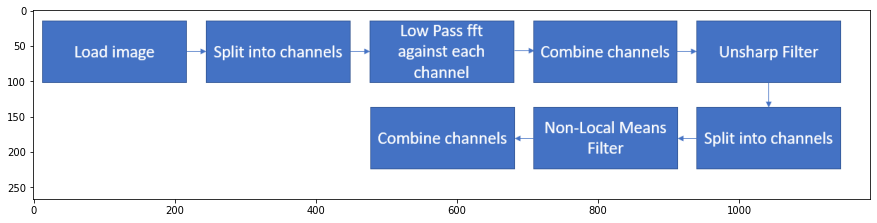

In [136]:
# # Import Flow
Flow = io.imread('https://github.com/hyuan10/CSC_8628/blob/main/Algorithm%20Flowchart%20RGB.PNG?raw=true')

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
p = plt.imshow(Flow)

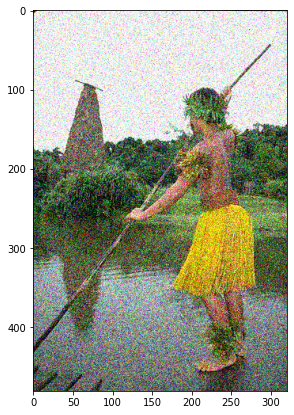

In [137]:
# Import Image

#im_10 = io.imread('https://github.com/hyuan10/CSC_8628/blob/main/noisy10/0009.png?raw=true') # Noisy 10
#im_25 = io.imread('https://github.com/hyuan10/CSC_8628/blob/main/noisy25/0009.png?raw=true') # Noisy 25
im_50 = io.imread('https://github.com/hyuan10/CSC_8628/blob/main/noisy50/0009.png?raw=true') # Noisy 50

im_clean = io.imread('https://github.com/hyuan10/CSC_8628/blob/main/original/0009.png?raw=true') # Clean

#im = im_10
#im = im_25
im = im_50


im_original = im # original image with noise


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
p = plt.imshow(im)


In [138]:
## Splitting into channels

im0 = im[:,:,0]
im1 = im[:,:,1]
im2 = im[:,:,2]

# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(1, 3, 1)
# p = plt.imshow(im0)

# ax = fig.add_subplot(1, 3, 2)
# p = plt.imshow(im1)

# ax = fig.add_subplot(1, 3, 3)
# p = plt.imshow(im2)

In [139]:
# Defining the required radius of the fourier mask

sig_est = np.mean(estimate_sigma(im, multichannel=True)) # Estimate the standard deviation of noise in the image

def rad(sig_est):	
  if(sig_est < 18):
	  return 100
  elif (18<sig_est<36):
    return 75
  elif (sig_est>36):
    return 75


r = rad(sig_est)

In [140]:
#Defining a low pass function for fft transform
def lpfft(im):
  im = img_as_float(im)

  imw = np.zeros_like(im)
  cx, cy = np.round(np.array(im.shape[0:2])/2)
  rr, cc = disk((cx, cy), r, shape=im.shape)
  imw[rr, cc] = 1

  imfft = fftshift(fft2(im))
  imm = np.log(np.abs(imfft)) #imfft exists as complex number 
  imfft[imw==0] = 0
  imf = np.abs(ifft2(imfft))

  return imf

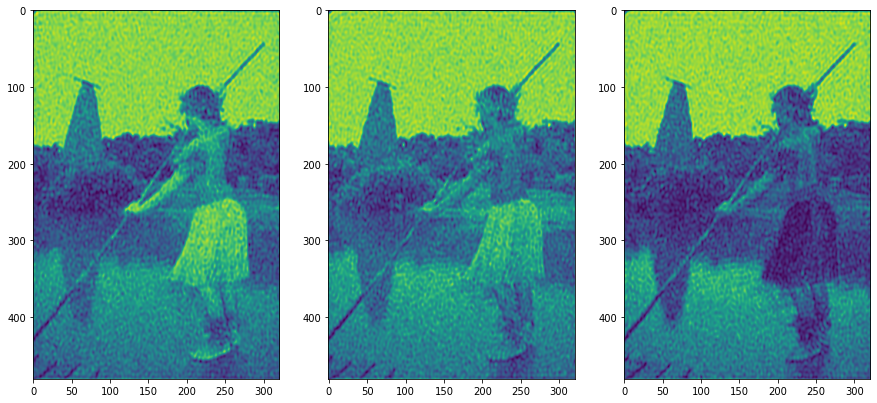

In [141]:
# Running the lp function for the different channels

im0 = lpfft(im0)
im1 = lpfft(im1)
im2 = lpfft(im2)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 3, 1)
p = plt.imshow(im0)

ax = fig.add_subplot(1, 3, 2)
p = plt.imshow(im1)

ax = fig.add_subplot(1, 3, 3)
p = plt.imshow(im2)

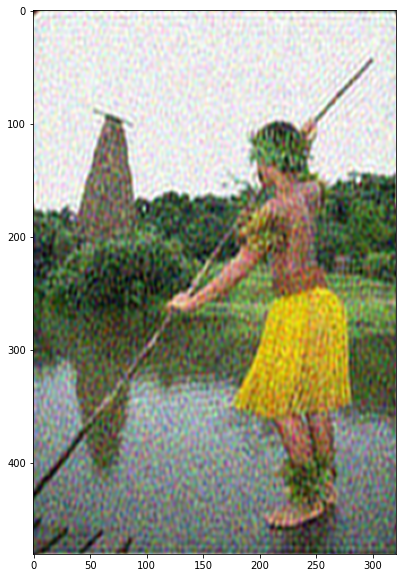

In [142]:
# Recombining different channels

im_stack = np.dstack((im0,im1,im2))
im_stack = img_as_float(im_stack)

im_stack[im_stack>1] = 1 # Setting max value to 1 where greater than 1

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
p = plt.imshow(im_stack, vmin=0, vmax=255)


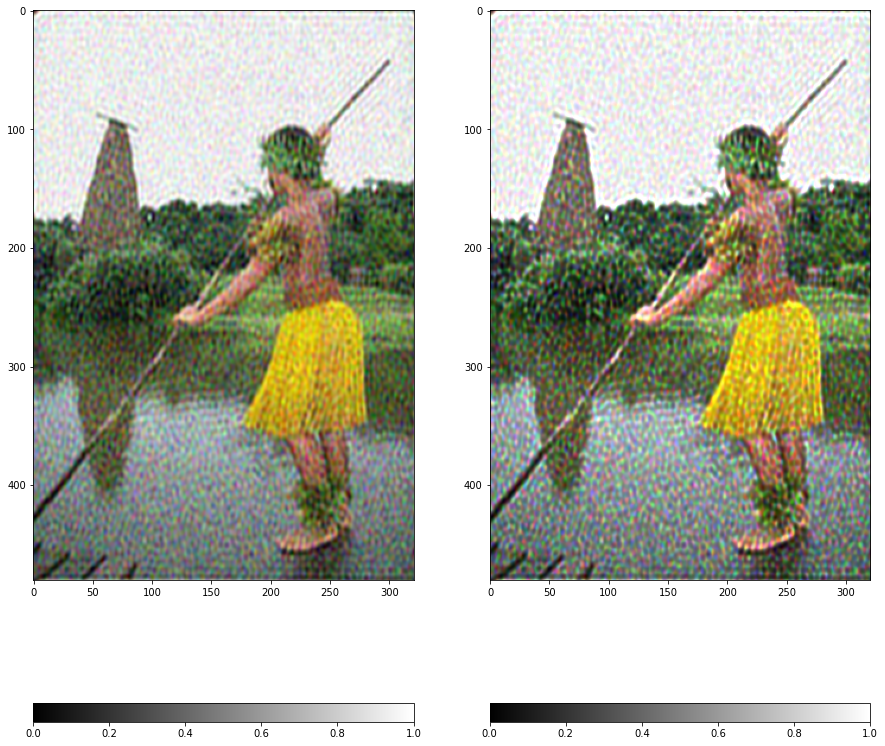

In [143]:
# Task 1

# Unsharp Filter - Edges
im = im_stack

img5 = gaussian(im, sigma=5, multichannel=True) # Guassian Blur

ime = im - img5 # Edges of image
ime[ime<0]=0

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1, 3, 1)
# p = plt.imshow(im, cmap='gray')
# c = plt.colorbar(orientation='horizontal')
# plt.clim(0, 1)

# ax = fig.add_subplot(1, 3, 2)
# p = plt.imshow(img5, cmap='gray')
# c = plt.colorbar(orientation='horizontal')
# plt.clim(0, 1)

# ax = fig.add_subplot(1, 3, 3)
# p = plt.imshow(ime, cmap='gray')
# c = plt.colorbar(orientation='horizontal')
# plt.clim(0, 1)

# Enhanced edges image

ien = im + 0.75*(ime)
ien[ien>1]=1

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 2, 1)
p = plt.imshow(im, cmap='gray')
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

ax = fig.add_subplot(1, 2, 2)
p = plt.imshow(ien, cmap='gray')
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

In [144]:
# Splitting the enhanced image into 3 channels

ien0 = ien[:,:,0]
ien1 = ien[:,:,1]
ien2 = ien[:,:,2]


In [145]:
# Define function for Sigma est and NLM filter

def sig_est(im):
  sig = np.mean(estimate_sigma(im, multichannel=True))

  return sig

def nlm(im, sig_est):

  nl = denoise_nl_means(im, h=2.5 * sig_est, sigma=sig_est, fast_mode=True)

  return nl


In [146]:
# Sigma estimation for different channels
ien0_sig = sig_est(ien0)
ien1_sig = sig_est(ien1)
ien2_sig = sig_est(ien2)

nlm0 = nlm(ien0, ien0_sig)
nlm1 = nlm(ien1, ien0_sig)
nlm2 = nlm(ien2, ien0_sig)

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1, 3, 1)
# p = plt.imshow(nlm0)
# plt.clim(0, 1)

# ax = fig.add_subplot(1, 3, 2)
# p = plt.imshow(nlm1)
# plt.clim(0, 1)

# ax = fig.add_subplot(1, 3, 3)
# p = plt.imshow(nlm2)
# plt.clim(0, 1)


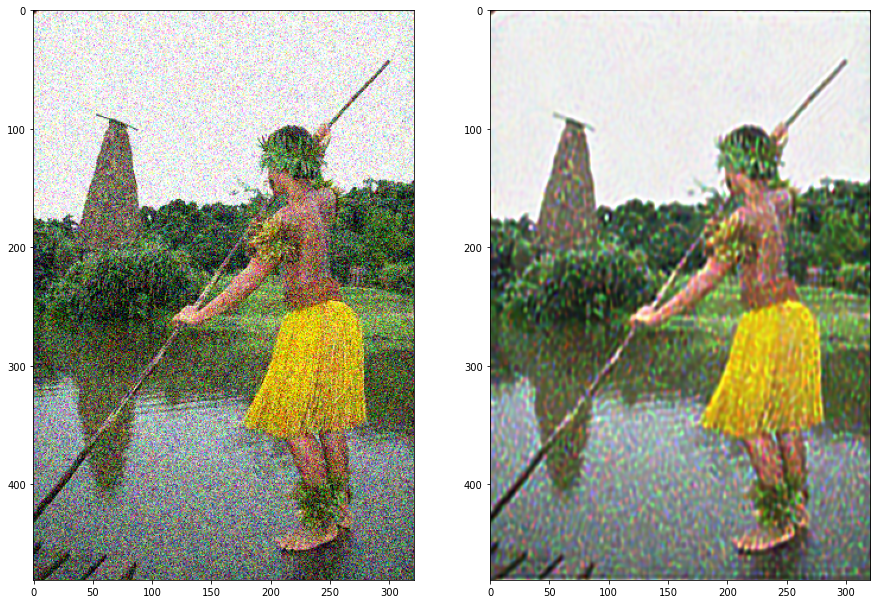

In [147]:
# Recombining different channels for NLM filter - Application of Fast Non-Local Means Algorithm for Noise Reduction Using Separable Colour Channels in Light Microscopy Images

nlm_stack = np.dstack((nlm0,nlm1,nlm2))
nlm_stack = img_as_float(nlm_stack)

nlm_stack[im_stack>1] = 1 # Setting max value to 1 where greater than 1

nlm_stack = img_as_ubyte(nlm_stack)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 2, 1)
p = plt.imshow(im_original, vmin=0, vmax=255)

ax = fig.add_subplot(1, 2, 2)
p = plt.imshow(nlm_stack, vmin=0, vmax=255)

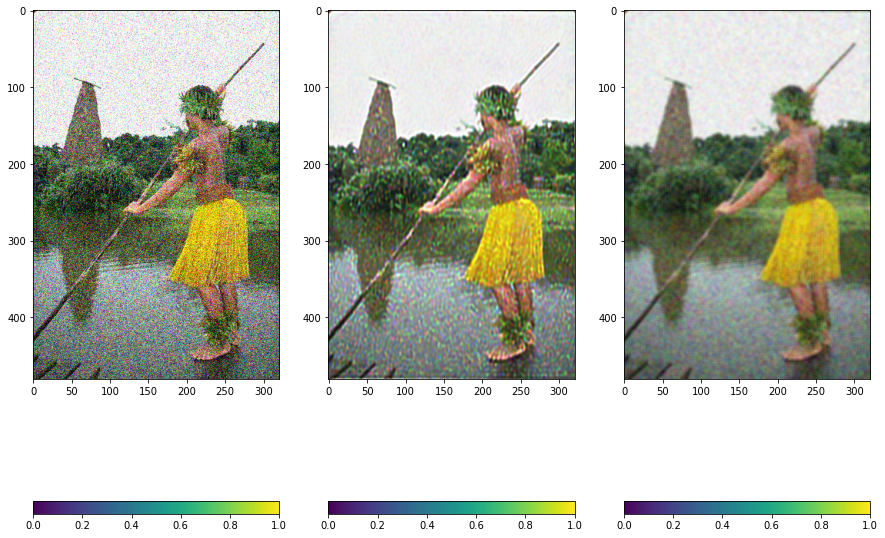

In [148]:
# # Task 2 - Mean filter

mean_im = cv2.blur(im_original, (5,5))

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 3, 1)
p = plt.imshow(im_original)
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

ax = fig.add_subplot(1, 3, 2)
p = plt.imshow(nlm_stack)
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

ax = fig.add_subplot(1, 3, 3)
p = plt.imshow(mean_im)
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

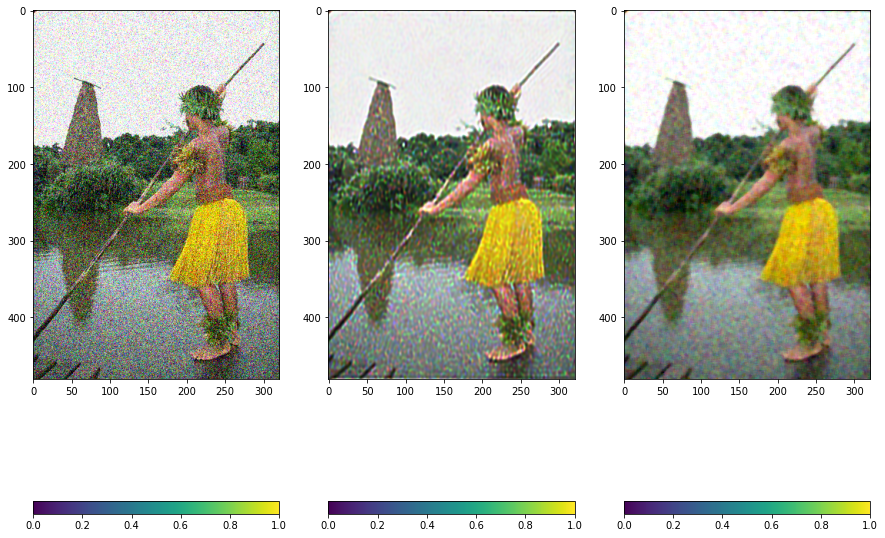

In [149]:
# Task 2 - Median filter

median_im = cv2.medianBlur(im_original,5)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 3, 1)
p = plt.imshow(im_original)
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

ax = fig.add_subplot(1, 3, 2)
p = plt.imshow(nlm_stack)
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

ax = fig.add_subplot(1, 3, 3)
p = plt.imshow(median_im)
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

/usr/local/lib/python3.8/dist-packages/skimage/restoration/_denoise.py:856: UserWarning: Wavelet thresholding was designed for use with orthogonal wavelets. For nonorthogonal wavelets such as bior6.8, results are likely to be suboptimal.
  out = _wavelet_threshold(image, wavelet=wavelet, method=method,
/usr/local/lib/python3.8/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


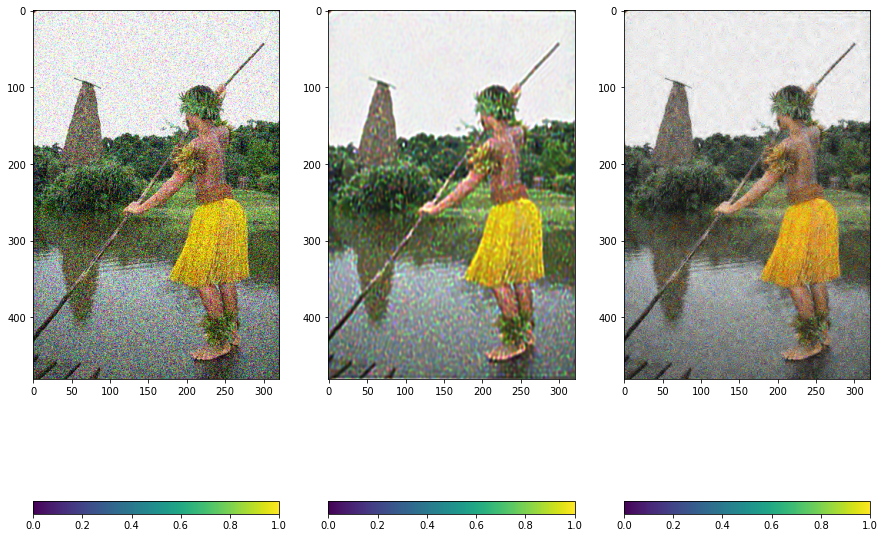

In [150]:
# # Task 2 - Wavelet denoising - VisuShrink

wl_im = img_as_float(im_original)

c = 4

sigma_est_vs = np.mean(estimate_sigma(wl_im, multichannel=True))

vs_im = denoise_wavelet(wl_im, method='VisuShrink', mode='soft', sigma=sigma_est_vs/c, wavelet_levels=3, wavelet='bior6.8', rescale_sigma=True) # sigma est divided by constant to control smoothing
vs_im[vs_im>1] = 1
vs_im[vs_im<0] = 0

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 3, 1)
p = plt.imshow(im_original)
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

ax = fig.add_subplot(1, 3, 2)
p = plt.imshow(nlm_stack)
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

ax = fig.add_subplot(1, 3, 3)
p = plt.imshow(vs_im)
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

vs_im = img_as_ubyte(vs_im)

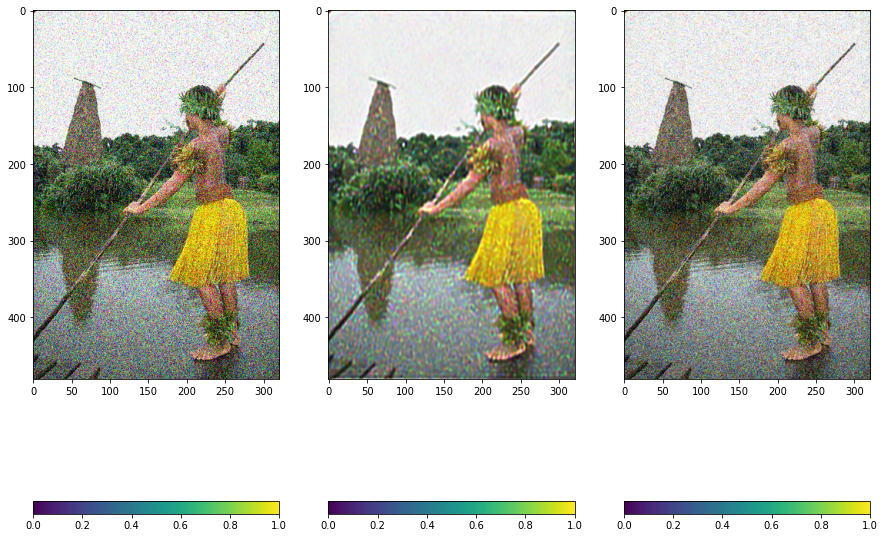

In [151]:
# Task 2 - Wavelet denoising - Bayes

b_im = denoise_wavelet(wl_im, method='BayesShrink', mode='soft', wavelet_levels=3, wavelet='bior6.8', rescale_sigma=True) 
b_im[b_im<0] = 0
b_im[b_im>1] = 1

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 3, 1)
p = plt.imshow(im_original)
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

ax = fig.add_subplot(1, 3, 2)
p = plt.imshow(nlm_stack)
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

ax = fig.add_subplot(1, 3, 3)
p = plt.imshow(b_im)
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 1)

b_im = img_as_ubyte(b_im)

In [152]:
# Task 3
# MSE - metric that represents the cumulative squared error between the processed and original image
mse_skimg_mean = metrics.mean_squared_error(im_clean, mean_im)
mse_skimg_median = metrics.mean_squared_error(im_clean, median_im)
mse_skimg_denoise = metrics.mean_squared_error(im_clean, nlm_stack)
mse_skimg_b = metrics.mean_squared_error(im_clean, b_im)
mse_skimg_vs = metrics.mean_squared_error(im_clean, vs_im)

print("im vs mean MSE" ,mse_skimg_mean)
print("im vs median MSE" ,mse_skimg_median)
print("im vs denoised MSE" ,mse_skimg_denoise)
print("im vs bayes MSE" ,mse_skimg_b)
print("im vs visushrink MSE" ,mse_skimg_vs)


im vs mean MSE 380.27542567729483
im vs median MSE 289.0276962800327
im vs denoised MSE 471.25995729734046
im vs bayes MSE 1238.515858057914
im vs visushrink MSE 654.3620982592945


In [153]:
# Task 3
# SSIM - metric that quantifies image quality degradation caused by processing

ssim_mean = ssim(im_clean,mean_im,data_range = mean_im.max()-mean_im.min(),multichannel = True)
ssim_median = ssim(im_clean,median_im,data_range = median_im.max()-median_im.min(),multichannel = True)
ssim_imd = ssim(im_clean,nlm_stack,data_range = nlm_stack.max()-nlm_stack.min(),multichannel = True)
ssim_b = ssim(im_clean,b_im,data_range = b_im.max()-b_im.min(),multichannel = True)
ssim_vs = ssim(im_clean,vs_im,data_range = vs_im.max()-vs_im.min(),multichannel = True)

print("im vs mean SSIM", ssim_mean)
print("im vs median SSIM", ssim_median)
print("im vs denoised SSIM", ssim_imd)
print("im vs bayes SSIM", ssim_b)
print("im vs visushrink SSIM", ssim_vs)

im vs mean SSIM 0.5355363603537081
im vs median SSIM 0.4831382190297589
im vs denoised SSIM 0.5206857062631224
im vs bayes SSIM 0.2256452330475858
im vs visushrink SSIM 0.35762436626471755
